<a href="https://colab.research.google.com/github/TomMaullin/BLM/blob/master/FS_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FS implementation in python

This code implements the Fisher Scoring algorithm for estimating the parameters of linear mixed effects models as described in [Demidenko 2013](https://www.wiley.com/en-us/Mixed+Models%3A+Theory+and+Applications+with+R%2C+2nd+Edition-p-9781118091579).

## Pip Installations

Pip install everything.

In [1]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install matplotlib


## Python Imports




We need:
 - `numpy` for matrix handling.
 - `scipy` for sparse matrix functions.
 - `pandas` for quick reading and writing of csv files.
 - `os` and `sys` for basic commandline functions
 - `time` for timing functions.
 - `matplotlib` for making displays.

In [0]:
import numpy as np
import cvxopt
import pandas as pd
import os
import time
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import sys

## Toy Dataset

This section read ins and formats a toy dataset. The files used here were generated in `R` and with **True** values (those with postfix `True`) being those used to generate the data and **Estimated** (those with postfix `REst`) values being the estimates `R`'s `lmer` package generated from this data.

In [0]:
# Make a data directory
if not os.path.isdir('/Data'):
  os.mkdir('/Data')
  
os.chdir('/Data')

# Clone small git repo containg some csv files.
if not os.path.isdir('/Data/BLMM-testdata'):
  !git clone https://github.com/TomMaullin/BLMM-testdata.git
  


### Z matrix

The below reads in Z and makes an image of Z transpose.


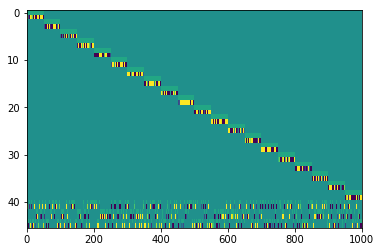

In [4]:
# Read in random effects design matrix and convert it into it's sparse format in
# cvxopt.
Z_3col=pd.read_csv('/Data/BLMM-testdata/Z_3col.csv',header=None).values
Z = scipy.sparse.csr_matrix((Z_3col[:,2].tolist(), \
                            ((Z_3col[:,0]-1).astype(np.int64), \
                             (Z_3col[:,1]-1).astype(np.int64))))

# Create an image of Z'
imshow(Z.toarray().transpose(), \
       interpolation='nearest', vmin=-5, vmax=5, aspect='auto')



### Estimated Random Effects matrix

The below reads in the Random effects variance predicted by `R`'s `lmer`.

In [0]:
# Read in estimated variance
RFXVar_REst = pd.read_csv('/Data/BLMM-testdata/estd_rfxvar.csv',header=None).values

### Y vector

The response vector is read in here:

In [0]:
Y=pd.read_csv('/Data/BLMM-testdata/Y.csv',header=None).values

### X matrix

The fixed effects design matrix is read in here. It consists of an intercept and two random (Gaussian) columns.


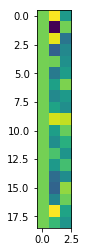

In [7]:
X=pd.read_csv('/Data/BLMM-testdata/X.csv',header=None).values

# Image of the first 20 rows of X
imshow(X[1:20,:])

### Number of Levels and Parameters

The number of levels is given by a vector with one entry for each grouping factor. e.g. nlevels=[10,2] means there are 10 levels for factor 1 and 2 levels for factor 2. 

The number of parameters is given by a vector with one entry for each grouping factor. e.g. nparams=[3,4] means there are 3 variables for factor 1 and 4 variables for factor 2.

In [0]:
nlevels = np.array([20,3])
nparams = np.array([2,2])

### True b values

The true recorded values of the random effects b vector in this example.

In [0]:
b_True=pd.read_csv('/Data/BLMM-testdata/true_b.csv',header=None).values

### True beta values

The true fixed effects parameters used to generate this example.

In [0]:
beta_True=pd.read_csv('/Data/BLMM-testdata/true_beta.csv',header=None).values

### Product Matrices

All products of matrices are calculated beforehand as it is both more computationally efficient and also similar to the setting we are interested in. 

In [11]:
# Z transpose Z
print(Z.shape)
ZtZ = np.matmul(Z.toarray().transpose(),Z.toarray()) # This works for products involving sparse
# Sparse 
# ZtZ = Z.transpose() * Z

# Z transpose X
XtZ = np.matmul(X.transpose(),Z.toarray())

# X transpose Z
ZtX = np.matmul(Z.toarray().transpose(),X)

# ZtY
ZtY = np.matmul(Z.toarray().transpose(),Y)

# YtZ
YtZ = np.matmul(Y.transpose(),Z.toarray())

# XtX
XtX = np.matmul(X.transpose(),X)

# XtY
XtY = np.matmul(X.transpose(),Y)

# YtX
YtX = np.matmul(Y.transpose(),X)

# YtX
YtY = np.matmul(Y.transpose(),Y)

(1000, 46)


## Helper Functions

This section contains miscellaneous functions used to help the `FS` function including functions to work out the duplication matrix.


###Matrix to Vector function

This function takes in a matrix and vectorizes it (i.e. transforms it to a vector of each of the columns of the matrix stacked on top of one another). Example:

$$\begin{bmatrix} a & b & c \\ d & e & f \\ g & h & i \\\end{bmatrix} \rightarrow \begin{bmatrix} a \\ d \\ g \\ b \\ e \\ h \\ c \\ f \\ i \end{bmatrix}$$.

In [12]:
def mat2vec(matrix):
  
  #Return vectorised matrix
  return(matrix.transpose().reshape(matrix.shape[0]*matrix.shape[1],1))

# Example:
matrix = np.random.randn(3,3)
print(matrix)
print(mat2vec(matrix))

[[-1.13554138 -1.86913126  0.13226088]
 [-0.77665361  1.28200347  1.29031668]
 [-1.23365759 -0.27247786  1.02978613]]
[[-1.13554138]
 [-0.77665361]
 [-1.23365759]
 [-1.86913126]
 [ 1.28200347]
 [-0.27247786]
 [ 0.13226088]
 [ 1.29031668]
 [ 1.02978613]]


###Matrix to Vector function

This function takes in a (symmetric, square) matrix and half-vectorizes it (i.e. transforms it to a vector of each of the columns of the matrix, below and including the diagonal, stacked on top of one another). Example:

$$\begin{bmatrix} a & b & c \\ b & d & e \\ c & e & f \\\end{bmatrix} \rightarrow \begin{bmatrix} a \\ b \\ c \\ d \\ e \\ f \end{bmatrix}$$.

In [13]:
def mat2vech(matrix):
  
  # Get lower triangular indices
  rowinds, colinds = np.tril_indices(matrix.shape[0]) #Try mat.transpose()[trilu]?
  
  # They're in the wrong order so we need to order them
  # To do this we first hash them
  indhash = colinds*matrix.shape[0]+rowinds
  
  # Sort permutation
  perm=np.argsort(indhash)
  
  # Return vectorised half-matrix
  return(np.array([matrix[rowinds[perm],colinds[perm]]]).transpose())

# Example:
matrix = np.random.randn(3,3)
print(matrix*matrix.transpose())
print(mat2vech(matrix*matrix.transpose()))

#print(vech2mat(invDupMat(3) @ mat2vec(matrix*matrix.transpose())))

[[0.01822102 0.00296636 0.89051255]
 [0.00296636 0.42588996 0.02318647]
 [0.89051255 0.02318647 0.13243242]]
[[0.01822102]
 [0.00296636]
 [0.89051255]
 [0.42588996]
 [0.02318647]
 [0.13243242]]


In [0]:
def vec2mat(vec):
  
  # Return matrix
  return(vec.reshape(np.int64(np.sqrt(vec.shape[0])),np.int64(np.sqrt(vec.shape[0]))).transpose())

# Example
#vec = np.array([[1,2,3,4]]).transpose()
#mat = vec2mat(vec)
#print(vec)
#print(mat)

In [0]:
def vech2mat(vech):
  
  # dimension of matrix
  n = np.int64((-1+np.sqrt(1+8*vech.shape[0]))/2)
  matrix = np.zeros((n,n))
  
  # Get lower triangular indices
  rowinds, colinds = np.tril_indices(matrix.shape[0])
  
  # They're in the wrong order so we need to order them
  # To do this we first hash them
  indhash = colinds*matrix.shape[0]+rowinds
  
  # Sort permutation
  perm=np.argsort(indhash)
  
  # Assign values to lower half
  matrix[rowinds[perm],colinds[perm]] = vech.reshape(vech.shape[0])
  
  # Assign values to upper half
  matrix[colinds[perm],rowinds[perm]] = vech.reshape(vech.shape[0])
  
  # Return vectorised half-matrix
  return(matrix)

# Example:
#vech = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]])
#matrix = vech2mat(vech)
#print(vech)
#print(matrix)

In [0]:
def vec2vech(vec):
  
  # Return vech
  return(mat2vech(vec2mat(vec)))

# Example
#vec = np.array([[1],[2],[3],[2],[4],[5],[3],[5],[6]])
#vech = vec2vech(vec)

#print(vec)
#print(vech)

In [0]:
def vech2vec(vech):
  
  # Return vec
  return(mat2vec(vech2mat(vech)))

# Example
#vech = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]])
#vec = vech2vec(vech)

#print(vech)
#print(vec)

In [0]:
def dupMat(n):
  
  # Make vech of 1:(n(n+1)/2)
  vech = np.arange(n*(n+1)/2)
  
  # Convert to vec
  vec = vech2vec(vech)
  
  # Make D (sparse one hot encoded vec)
  D = scipy.sparse.csr_matrix((np.ones(n**2),(np.arange(n**2),np.int64(vec).reshape(vec.shape[0]))))
  
  return(D)

# Example
#print(dupMat(3))

In [19]:
def invDupMat(n):
  
  
  # Make vech of 1:(n(n+1)/2)
  vech = np.arange(n*(n+1)/2)
  
  # Convert to vec
  vec = np.int64(vech2vec(vech))
  vec = vec.reshape(vec.shape[0])
  
  # Work out frequency of each entry
  freq = 1/np.bincount(vec)
  
  # Work out duplication matrix
  D = scipy.sparse.csr_matrix((freq[vec],(vec,np.arange(n**2))))
  
  return(D)

# Example
print(invDupMat(3))

  (0, 0)	1.0
  (1, 1)	0.5
  (1, 3)	0.5
  (2, 2)	0.5
  (2, 6)	0.5
  (3, 4)	1.0
  (4, 5)	0.5
  (4, 7)	0.5
  (5, 8)	1.0


In [0]:
def blockInverse(matrix, blockSize, numBlocks):

  invMatrix = scipy.sparse.csr_matrix((np.array([]), (np.array([]),np.array([]))),shape=matrix.shape)
  
  # For each level, invert the corresponding block on the diagonal
  for i in range(numBlocks):
    
    # The block is nparams by nparams
    blockInds = np.ix_(np.arange(i*blockSize,(i+1)*blockSize),np.arange(i*blockSize,(i+1)*blockSize))
    
    # Get the block
    block = matrix[blockInds]
    
    # Replace it with it's inverse
    invMatrix[blockInds]=scipy.sparse.linalg.inv(block)
    
  return(invMatrix)

# Example - need to have loaded in data first

# Get ZtZ just for the first grouping factor
firstFactorIndices = np.ix_(np.arange(nlevels[0]*nparams[0]),np.arange(nlevels[0]*nparams[0]))
ZtZ_f1 = ZtZ[firstFactorIndices]

# Compute the block inverse for ZtZ_f1
#t1 = time.time()
#ZtZ_f1_inv = blockInverse(matrix=ZtZ_f1, blockSize=nparams[0], numBlocks=nlevels[0])
#t2 = time.time()
#blockInverse_time = t2-t1

# Compare it to the inverse scipy would calculate
#t1 = time.time()
#ZtZ_f1_inv_sp = scipy.sparse.linalg.inv(ZtZ_f1)
#t2 = time.time()
#scipyInverse_time = t2-t1

#print(blockInverse_time)
#print(scipyInverse_time)


In [21]:
def recursiveInverse(M, nparams, nlevels):
  
  # Work out qc
  qc = nparams[-1]*nlevels[-1]
  
  # Make q
  q = M.shape[0]
  
  # Get A, B and C where M=[[A,B],[B',C]]
  # A
  A_inds = np.ix_(np.arange(0,(q-qc)),np.arange(0,(q-qc)))
  A = M[A_inds]
  
  # B
  B_inds = np.ix_(np.arange(0,(q-qc)),np.arange((q-qc),q))
  B = M[B_inds].toarray() # B is dense
  
  # C
  C_inds = np.ix_(np.arange((q-qc),q),np.arange((q-qc),q))
  C = M[C_inds].toarray() # C is small and now only involved in dense mutliplys
  
  # Recursive inverse A
  if nparams[:-1].shape[0] > 1:
    
    Ainv = recursiveInverse(A, nparams[:-1], nlevels[:-1]).toarray()
    
  else:
    
    #Ainv = blockInverse(A, nparams[0], nlevels[0]) - much slower
    Ainv = scipy.sparse.linalg.inv(scipy.sparse.csc_matrix(A)).toarray()
  
  # Schur complement
  S = C-np.matmul(np.matmul(B.transpose(),Ainv),B)
  Sinv = np.linalg.inv(S)
  
  # Top Left Hand Side of inverse
  TLHS = Ainv + np.matmul(np.matmul(np.matmul(np.matmul(Ainv,B),Sinv),B.transpose()),Ainv)
  
  
  # Top Right Hand Side of inverse
  TRHS = -np.matmul(np.matmul(Ainv,B),Sinv)
  
  
  # Bottom Right Hand Side of inverse
  BRHS = Sinv
  
  # Join together
  top = np.hstack((TLHS,TRHS))
  bottom = np.hstack((TRHS.transpose(), BRHS))
  
  # Make Minv
  Minv = np.vstack((top, bottom))
  
  return(Minv)

# Example
t1 = time.time()
ZtZinv_rec = recursiveInverse(ZtZ, nparams, nlevels)
t2 = time.time()
inv_rec_time = t2-t1

t1 = time.time()
ZtZinv_sp = scipy.sparse.linalg.inv(scipy.sparse.csc_matrix(ZtZ))
t2 = time.time()
inv_sp_time = t2-t1

t1 = time.time()
ZtZinv_np = np.linalg.inv(ZtZ.toarray())
t2 = time.time()
inv_np_time = t2-t1


print('Distance (norm) from identity (scipy)')
print(np.linalg.norm(np.matmul(ZtZinv_sp.toarray(),ZtZ.toarray())-np.eye(ZtZ.shape[0])))
print('Distance (norm) from identity (numpy)')
print(np.linalg.norm(np.matmul(ZtZinv_np,ZtZ.toarray())-np.eye(ZtZ.shape[0])))
print('Distance (norm) from identity (rec)')
print(np.linalg.norm(np.matmul(ZtZinv_rec,ZtZ.toarray())-np.eye(ZtZ.shape[0])))

print(inv_sp_time)
print(inv_np_time)
print(inv_rec_time)


AttributeError: ignored

#### Sum of square residuals

The function below calculates the sum of the square residuals, $e^Te$, using the below formula:

$$e^Te = (Y-X\beta)^T(Y-X\beta)$$ 
$$=Y^TY - 2Y^TX\beta + \beta^T X^TX \beta$$


----

This function takes the following inputs:

----

 - `YtX`: $Y$ transpose multiplied by $X$ ($Y^TX$ in the above notation).
 - `YtY`: $Y$ transpose multiplied by $Y$ ($Y^TY$ in the above notation).
 - `XtX`: $X$ transpose multiplied by $X$ ($X^TX$ in the above notation).
 - `beta`: An estimate of the parameter vector ($\beta$ in the above notation).
 
----

It returns as outputs:

----


 - `ete`: The sum of square residuals ($e^Te$ in the above notation).

In [22]:
def ssr(YtX, YtY, XtX, beta):
  
  # Return the sum of squared residuals
  return(YtY - 2*YtX @ beta + beta.transpose() @ XtX @ beta)

t1 = time.time()
ssr(YtX, YtY, XtX, np.array([[1],[2],[3]]))
t2 = time.time()
print(t2-t1)


0.0010385513305664062


#### Get Factor/Level Indices

This function gives the indices of the columns of the $Z$ matrix which correspond to factor $k$ level $j$. 


----

This function takes the following inputs:

----

 - `k`: The grouping factor we need the columns of.
 - `j`: The level of the grouping factor $k$ which we are interested in.
 - `nlevels`: A vector containing the number of levels for each factor, e.g. `nlevels=[3,4]` would mean the first factor has 3 levels and the second factor has 4 levels.
 - `nparams`: A vector containing the number of parameters for each factor, e.g. `nlevels=[2,1]` would mean the first factor has 2 parameters and the second factor has 1 parameter.
 
----

It returns as outputs:

----

- `Ikj`: The indices of the columns of $Z$ corresponding to factor $k$ level $j$.

In [23]:
import numba

@numba.jit
# k and j are both zero indexed
def faclev_indices(k, j, nlevels, nparams):
  
  # Work out the starting point of the indices
  start = np.concatenate((np.array([0]), np.cumsum(nlevels*nparams)))[k] + nparams[k]*j
  
  # work out the end point of the indices
  end = start + nparams[k]
  
  return(np.arange(start, end))

t1 = time.time()
faclev_indices(0, 1, nlevels, nparams)
t2 = time.time()

print(t2-t1)

0.5320243835449219


In [24]:
t1 = time.time()
faclev_indices(0, 1, nlevels, nparams)
t2 = time.time()

print(t2-t1)

8.225440979003906e-05


#### Initial Sigma

The function below returns an initial estimate for the Fixed Effects Variance, $\sigma^2$. The estimator used is based on the suggested OLS estimator in Demidenko (2012) and is given by:

$$\hat{\sigma}^2_{OLS}=\frac{1}{n}(Y-X\beta)^T(Y-X\beta)$$
$$=\frac{1}{n}e^Te$$

----

This function takes the following inputs:

----

 - `ete`: The sum of square residuals ($e^Te$ in the above notation).
 - `n`: The total number of observations ($n$ in the above notation).
 
----

It returns as outputs:

----

- `sigma2`: The OLS estimate of $\sigma^2$ ($\hat{\sigma}^2_{OLS}$ in the above notation).

In [0]:
def initSigma2(ete, n):

  # Return the OLS estimate of sigma
  return(1/n*ete[0,0])

#### Initial D_k

The function below returns an initial estimate for the Random Effects Variance matrix for the $k^{th}$ grouping factor, $D_k$. The estimator used is an adaption of the suggested estimator in Demidenko (2012) and is given by:

$$vec(\hat{D}_{k})=\bigg[\sum_{j=1}^{l_k}(Z_{(k,j)}^TZ_{(k,j)}) \otimes (Z_{(k,j)}^TZ_{(k,j)})\bigg]^{-1}vec\bigg(\sum_{j=1}^{l_k}[\hat{\sigma}^{-2}_{OLS}Z_{(k,j)}^Tee^TZ_{(k,j)} - Z_{(k,j)}^TZ_{(k,j)}]\bigg)$$

Or:

$$\hat{D}_{k}=matrix\bigg(\bigg[\sum_{j=1}^{l_k}(Z_{(k,j)}^TZ_{(k,j)}) \otimes (Z_{(k,j)}^TZ_{(k,j)})\bigg]^{-1}vec\bigg(\sum_{j=1}^{l_k}[\hat{\sigma}^{-2}_{OLS}Z_{(k,j)}^Tee^TZ_{(k,j)} - Z_{(k,j)}^TZ_{(k,j)}]\bigg)\bigg)$$

----

This function takes the following inputs:

----

 - `k`: The grouping factor we wish to estimate $D$ for ($k$ in the above notation)
 - `lk`: The number of levels belonging to grouping factor $k$ ($l_k$ in the above notation).
 - `ZtZ`: The $Z$ matrix transposed and then multiplied by itself ($Z^TZ$ in the above notation).
 - `Zte`: The $Z$ matrix transposed and then multiplied by the OLS residuals ($Z^Te=Z^T(Y-X\beta)$ in the above notation).
 - `sigma2`: The OLS estimate of $\sigma^2$ ($\hat{\sigma}^2_{OLS}$ in the above notation).
 
----

It returns as outputs:

----

- `Dkest`: The inital estimate of $D_k$ ($\hat{D}_k$ in the above notation).


###CHECK DERIVATION

In [26]:
import numba

@numba.jit
def initDk(k, lk, ZtZ, Zte, sigma2):
  
  # Initalize D to zeros
  invSig2ZteetZminusZtZ = np.zeros((nparams[k],nparams[k]))
  
  # For each level j we need to add a term
  for j in np.arange(nlevels[k]):
    
    Ikj = faclev_indices(k, j, nlevels, nparams)

    # Work out Z_(k, j)'Z_(k, j)
    ZkjtZkj = ZtZ[np.ix_(Ikj,Ikj)]
    
    # Work out Z_(k,j)'e
    Zkjte = Zte[Ikj,:]
    
    if j==0:
      
      # Add first Z_(k,j)'Z_(k,j) kron Z_(k,j)'Z_(k,j)
      ZtZkronZtZ = np.kron(ZkjtZkj,ZkjtZkj.transpose())
      
      # Add first \sigma^{-2}Z'ee'Z - Z_(k,j)'Z_(k,j)
      invSig2ZteetZminusZtZ = 1/sigma2*(Zkjte @ Zkjte.transpose()) - ZkjtZkj
      
    else:
      
      # Add next Z_(k,j)'Z_(k,j) kron Z_(k,j)'Z_(k,j)
      ZtZkronZtZ = ZtZkronZtZ + np.kron(ZkjtZkj,ZkjtZkj.transpose())
      
      # Add next \sigma^{-2}Z'ee'Z - Z_(k,j)'Z_(k,j)
      invSig2ZteetZminusZtZ = invSig2ZteetZminusZtZ + 1/sigma2*(Zkjte @ Zkjte.transpose()) - ZkjtZkj
  
  # Work out the final term.
  Dkest = vec2mat(np.linalg.inv(ZtZkronZtZ) @ mat2vec(invSig2ZteetZminusZtZ)) 
  
  return(Dkest)

Zte = ZtY-ZtX @ np.array([[1],[2],[3]])

t1 = time.time()
initDk(1, nlevels[1], ZtZ, Zte , 1)
t2 = time.time()

print(t2-t1)

t1 = time.time()
initDk(1, nlevels[1], ZtZ, Zte , 1)
t2 = time.time()

print(t2-t1)

0.8649301528930664
0.0005714893341064453


#### Non-negative Definite D

The below function takes in a covariance matrix $D$ and finds nearest projection onto the space of non-negative definite matrices $\mathbb{D}_+$. It uses the following method taken from Demidenko (2012), page 105:

If $D$ is non-negative definite and has eigenvalue decomposition $D=P\Lambda P^T$ it's closest projection into $\mathbb{D}_+$ is defined by the matrix below:

$$\hat{D}_+ = P\Lambda_+P'$$

Where $\Lambda_+$ is defined by the elementwise maximum of $\Lambda$ and 0; i.e. $\Lambda_{+(i,j)} = max(\Lambda_{+(i,j)},0)$.

Note: This is not to be confused with the generalized inverse of the duplication matrix $\mathcal{D}^+$.

----

This function takes the following inputs:

----

 - `D`: A square symmetric matrix.
 
----

It returns as outputs:

----

- `D_nnd`: The nearest projection of $D$ onto the space of non-negative definite matrices $\mathbb{D}_+$.

In [0]:
def makeDnnd(D):
  
  # Check if we have negative eigenvalues
  if not np.all(np.linalg.eigvals(D)>0):
  
    # If we have negative eigenvalues
    eigvals,eigvecs = np.linalg.eigh(D)
    
    # Work out elementwise max of lambda and 0
    lamplus = np.diag(np.maximum(eigvals,0))
    
    # Work out D+
    D_nnd = eigvecs @ lamplus @ np.linalg.inv(eigvecs)
    
  else:
    
    # D is already non-negative in this case
    D_nnd = D
    
  return(D_nnd)
  

#### Derivative of $l$ with respect to $\beta$

The below function calculates the derivative of the log likelihood with respect to $\beta$. This is given by the following equation:

$$\frac{\delta l}{\delta \beta} = \sigma^{-2}X'(I+ZDZ')^{-1}(Y-X\beta)$$
$$ = \sigma^{-2}X'(I-ZD(I+Z'ZD)^{-1}Z')(Y-X\beta)$$
$$ = \sigma^{-2}X'(Y-X\beta)-X'ZD(I+Z'ZD)^{-1}Z'(Y-X\beta) $$
$$ = \sigma^{-2}X'e-X'ZD(I+Z'ZD)^{-1}Z'e$$

----

This function takes the following inputs:

----

 - `XtZ`: The $X$ matrix transposed and then multiplied by Z ($X^TZ$ in the above notation).
 - `Zte`: The $Z$ matrix transposed and then multiplied by the OLS residuals ($Z^Te=Z^T(Y-X\beta)$ in the above notation).
 - `sigma2`: The fixed effects variance ($\sigma^2$ in the above notation).
 - `DinvIplusZtZD`: The product $D(I+Z'ZD)^{-1}$.
 
----

It returns as outputs:

----

- `dldb`: The derivative of $l$ with respect to $\beta$.



In [28]:
def get_dldB(sigma2, Xte, XtZ, DinvIplusZtZD, Zte):
  
  # Return the derivative
  return(1/sigma2*(Xte - (XtZ @ DinvIplusZtZD @ Zte)))

### Test example

p = X.shape[1]
beta = np.random.randn(p,1)

sigma2=1.1
D = np.array([])
q=Z.shape[1]
n=Z.shape[0]
for i in np.arange(len(nparams)):
  
  for j in np.arange(nlevels[i]):
    
    if i == 0 and j == 0:

      D = initDk(i, nlevels[i], ZtZ, Zte, sigma2)

    else:

      D = scipy.linalg.block_diag(D, initDk(i, nlevels[i], ZtZ, Zte, sigma2))
      
IplusZtZD = np.eye(q) + ZtZ @ D
DinvIplusZtZD = D @ np.linalg.inv(IplusZtZD)

print(X.shape)

dldb1 = (sigma2)**(-1)*(X.transpose() @ np.linalg.inv(np.eye(n) + Z @ D @ Z.transpose()) @ (Y - X @ beta))

Xte = XtY- XtX @ beta

Zte = ZtY- ZtX @ beta

DinvIplusZtZD = D @ np.linalg.inv(np.eye(q) + ZtZ @ D)

dldb2 = get_dldB(sigma2, Xte, XtZ, DinvIplusZtZD, Zte)

print(dldb1)
print(dldb2)


print(dldb2-dldb1)

(1000, 3)
[[1.93555086e-01]
 [1.15522847e+03]
 [2.28534201e+03]]
[[1.93555086e-01]
 [1.15522847e+03]
 [2.28534201e+03]]
[[-2.39530590e-10]
 [-3.92567472e-08]
 [ 5.93772711e-08]]


#### Derivative of $l$ with respect to $\sigma^2$

The below function calculates the derivative of the log likelihood with respect to $\beta$. This is given by the following equation:

$$\frac{\delta l}{\delta \sigma^2} = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4}(Y-X\beta)'(I+ZDZ')^{-1}(Y-X\beta)$$
$$  = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4}e'(I+ZDZ')^{-1}e$$
$$  = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4}e'(I-ZD(I+ZZ'D)^{-1}Z')e$$
$$  = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4}(e'e-e'ZD(I+ZZ'D)^{-1}Z'e)$$

----

This function takes the following inputs:

----

 - `n`: The number of observations.
 - `ete`: The OLS residuals transposed and then multiplied by themselvess ($e^Te=(Y-X\beta)^T(Y-X\beta)$ in the above notation).
 - `Zte`: The $Z$ matrix transposed and then multiplied by the OLS residuals ($Z^Te=Z^T(Y-X\beta)$ in the above notation).
 - `sigma2`: The fixed effects variance ($\sigma^2$ in the above notation).
 - `DinvIplusZtZD`: The product $D(I+Z'ZD)^{-1}$.
 
----

It returns as outputs:

----

- `dldsigma2`: The derivative of $l$ with respect to $\sigma^2$.

In [0]:
def get_dldsigma2(n, ete, Zte, sigma2, DinvIplusZtZD):
  
  return(-n/(2*sigma2) + 1/(2*(sigma2**2))*(ete - (Zte.transpose() @ DinvIplusZtZD @ Zte)))


Zte = Z.toarray().transpose() @ (Y - X @ beta)
ete = (Y - X @ beta).transpose() @ (Y - X @ beta)
DinvIplusZtZD = D @ np.linalg.inv(np.eye(q) + ZtZ @ D)

t1 = time.time()
dldsigma2_1 = get_dldsigma2(n, ete, Zte, sigma2, DinvIplusZtZD)
t2 = time.time()
print(t2-t1)

dldsigma2_2 = -n/(2*sigma2) + 1/(2*(sigma2**2))*(Y - X @ beta).transpose() @ np.linalg.inv(np.eye(n) + (Z.toarray() @ D @ Z.toarray().transpose())) @ (Y - X @ beta)

print(dldsigma2_1)
print(dldsigma2_2)
print(dldsigma2_1-dldsigma2_2)

print(np.linalg.inv(np.eye(n) + (Z @ D @ Z.transpose())))
print(np.eye(n) - Z.toarray() @ D @ np.linalg.inv(np.eye(q) + ZtZ @ D) @ Z.toarray().transpose())

0.00012540817260742188
[[-2.33521159]]
[[10.97946868]]
[[-13.31468027]]
[[ 9.05569208e-01 -4.46146506e-02  1.92709693e-02 ...  3.49241881e-05
   3.57009943e-05  3.96111077e-04]
 [-4.42812428e-02  9.66737543e-01 -6.33330291e-03 ... -6.26483911e-03
   2.22355156e-03  5.71088528e-04]
 [ 1.88888446e-02 -6.27517014e-03  9.56050899e-01 ...  1.07749877e-03
   8.43216493e-04  1.16499462e-03]
 ...
 [ 4.01576600e-05 -6.27041686e-03  1.08893874e-03 ...  9.67295703e-01
  -3.67083742e-02 -1.51959799e-02]
 [ 3.62751901e-05  2.23650686e-03  8.37377586e-04 ... -3.68445061e-02
   8.96421636e-01 -4.68844100e-03]
 [ 3.93917453e-04  5.51442963e-04  1.15986812e-03 ... -1.52108335e-02
  -5.08784420e-03  9.73739640e-01]]
[[ 9.05978359e-01 -4.44241621e-02  1.92446573e-02 ...  3.83422612e-05
   3.95035872e-05  3.91288846e-04]
 [-4.44248288e-02  9.66705375e-01 -6.23251256e-03 ... -6.26339238e-03
   2.23376666e-03  5.58347037e-04]
 [ 1.92445376e-02 -6.23262853e-03  9.55891271e-01 ...  1.08577047e-03
   8.3930007

#### Derivative of $l$ with respect to $D_k$

The below function calculates the derivative of the log likelihood with respect to $D_k$, the random effects covariance matrix for factor $k$. This is given by the following equation:

$$\frac{\delta l}{\delta D_k} = \frac{1}{2}\sum_{j=1}^{l_k}(T_{(k,j)}u)(T_{(k,j)}u)'-\frac{1}{2}\sum_{j=1}^{l_k}T_{(k,j)}T_{(k,j)}'$$

Where $T_{(i,j)}=Z'_{(i,j)}(I+ZDZ')^{-\frac{1}{2}}$ and $u=\sigma^{-1}(I+ZDZ')^{-\frac{1}{2}}(Y-X\beta)\sim N(0,\mathbb{I})$.

$$= \frac{1}{2\sigma^2}\sum_{j=1}^{l_k}Z'_{(k,j)}(I+ZDZ')^{-1}ee'(I+ZDZ')^{-1}Z_{(k,j)} - \frac{1}{2}\sum_{j=1}^{l_k}Z'_{(k,j)}(I+ZDZ')^{-1}Z_{(k,j)}$$

$$= \frac{1}{2\sigma^2}\sum_{j=1}^{l_k}Z'_{(k,j)}(I-ZD(I+Z'ZD)^{-1}Z')ee'(I-ZD(I+Z'ZD)^{-1}Z')'Z_{(k,j)} - \frac{1}{2}\sum_{j=1}^{l_k}Z'_{(k,j)}(I-ZD(I+Z'ZD)^{-1})Z_{(k,j)}$$

$$= \frac{1}{2\sigma^2}\sum_{j=1}^{l_k}(Z'_{(k,j)}e-Z'_{(k,j)}ZD(I+Z'ZD)^{-1}Z'e)(Z'_{(k,j)}e-Z'_{(k,j)}ZD(I+Z'ZD)^{-1}Z'e)' - \frac{1}{2}\sum_{j=1}^{l_k}Z'_{(k,j)}Z_{(k,j)}-Z'_{(k,j)}ZD(I+Z'ZD)^{-1}Z'Z_{(k,j)}$$

----

This function takes the following inputs:

----

 - `k`: The factor we wish to estimate the derivative of the covariance matrix of.
 - `nlevels`: A vector containing the number of levels for each factor, e.g. `nlevels=[3,4]` would mean the first factor has 3 levels and the second factor has 4 levels.
 - `nparams`: A vector containing the number of parameters for each factor, e.g. `nlevels=[2,1]` would mean the first factor has 2 parameters and the second factor has 1 parameter.
 - `ZtZ`: The $Z$ matrix transposed and then multiplied by itself ($Z^TZ$ in the above notation).
 - `Zte`: The $Z$ matrix transposed and then multiplied by the OLS residuals ($Z^Te=Z^T(Y-X\beta)$ in the above notation).
 - `sigma2`: The fixed effects variance ($\sigma^2$ in the above notation).
 - `DinvIplusZtZD`: The product $D(I+Z'ZD)^{-1}$.
 
----

It returns as outputs:

----

- `dldD`: The derivative of $l$ with respect to $D_k$.

In [29]:
import numba

@numba.jit
def get_dlDk(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD):

  # Initalize the derivative to zeros
  dldDk = np.zeros((nparams[k],nparams[k]))

  # For each level j we need to add a term
  for j in np.arange(nlevels[k]):

    # Get the indices for the kth factor jth level
    Ikj = faclev_indices(k, j, nlevels, nparams)

    # Get (the kj^th columns of Z)^T multiplied by Z
    Z_kjtZ = ZtZ[Ikj,:]
    Z_kjte = Zte[Ikj,:]

    # Get the first term of the derivative
    invZ_kjtVinve = Z_kjte - (Z_kjtZ @ DinvIplusZtZD @ Zte)
    firstterm = 1/sigma2 * (invZ_kjtVinve @ invZ_kjtVinve.transpose())
    
    # Get (the kj^th columns of Z)^T multiplied by (the kj^th columns of Z)
    Z_kjtZ_kj = ZtZ[np.ix_(Ikj,Ikj)]
    secondterm = Z_kjtZ_kj - (Z_kjtZ @ DinvIplusZtZD @ Z_kjtZ.transpose())
      
    if j == 0:
      
      # Start a running sum over j
      dldDk = firstterm - secondterm
      
    else:
    
      # Add these to the running sum
      dldDk = dldDk + firstterm - secondterm

  # Halve the sum (the coefficient of a half was not included in the above)
  dldDk = dldDk/2

  # Store it in the dictionary
  return(dldDk)

IplusZtZD = np.eye(q) + ZtZ @ D
DinvIplusZtZD = D @ np.linalg.inv(IplusZtZD)

ZtZ = Z.toarray().transpose() @ Z.toarray()
Zte = Z.toarray().transpose() @ (Y - X @ beta)

k=0
t1 = time.time()
dldDk = get_dlDk(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD)
t2 = time.time()
print(t2-t1)

t1 = time.time()
dldDk = get_dlDk(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD)
t2 = time.time()
print(t2-t1)

0.6593673229217529
0.0009176731109619141


#### Covariance of $\frac{\delta l}{\delta \text{vech}(D_{k_1})}$ and $\frac{\delta l}{\delta \text{vech}(D_{k_2})}$

The below function calculates the covariance between the derivative of the log likelihood with respect to $\text{vech}(D_{k_1})$ and the derivative with respect to $\text{vech}(D_{k_2})$.

$$\text{cov}\bigg(\frac{\delta l(\theta | y)}{\delta \text{vech}(D_{k_2})},\frac{\delta l(\theta | y)}{\delta \text{vech}(D_{k_2})}\bigg)=\frac{1}{2}\mathcal{D}_{k_1}^+\sum_{j=1}^{l_{k_2}}\sum_{i=1}^{l_{k_1}}(R_{(k_1,k_2,i,j)}\otimes R_{(k_1,k_2, i,j)}')\mathcal{D}_{k_2}^{+'}$$



Where $R_{(k_1,k_2,i,j)}=Z_{(k_1,i)}'(I+ZDZ')^{-1}Z_{(k_2,j)}=Z_{(k_1,i)}'Z_{(k_2,j)} - Z_{(k_1,i)}'ZD(I+Z'ZD)^{-1}Z_{(k_2,j)}$.

----

This function takes the following inputs:

----

 - `k1`: The number of the first factor ($k_1$ in the above notation).
 - `k2`: The number of the second factor ($k_2$ in the above notation).
 - `nlevels`: A vector containing the number of levels for each factor, e.g. `nlevels=[3,4]` would mean the first factor has 3 levels and the second factor has 4 levels.
 - `nparams`: A vector containing the number of parameters for each factor, e.g. `nlevels=[2,1]` would mean the first factor has 2 parameters and the second factor has 1 parameter.
 - `ZtZ`: $Z$ transpose multiplied by $Z$.
 - `DinvIplusZtZD`: $D(I+Z'ZD)^{-1}$ in the above notation.
 - `invDupMatdict`: A dictionary of inverse duplication matrices such that `invDupMatdict[k]` = $\mathcal{D}_k^+$
 
----

It returns as outputs:

----

- `covdldDk1dldk2`: The covariance between the derivative of the log likelihood with respect to $\text{vech}(D_{k_1})$ and the derivative with respect to $\text{vech}(D_{k_2})$.



In [30]:
import numba

@numba.jit
def get_covdldDk1Dk2(k1, k2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict):
  
  # Sum of R_(k1, k2, i, j) kron R_(k1, k2, i, j) over i and j 
  for i in np.arange(nlevels[k1]):

    for j in np.arange(nlevels[k2]):
      
      # Get the indices for the k1th factor jth level
      Ik1i = faclev_indices(k1, i, nlevels, nparams)
      Ik2j = faclev_indices(k2, j, nlevels, nparams)

      # Work out R_(k1, k2, i, j)
      Rk1k2ij = ZtZ[np.ix_(Ik1i,Ik2j)] - (ZtZ[Ik1i,:] @ DinvIplusZtZD @ ZtZ[:,Ik2j])

      # Work out Rk1k2ij kron Rk1k2ij
      RkRt = np.kron(Rk1k2ij,Rk1k2ij.transpose())
      
      # Add together
      if (i == 0) and (j == 0):
      
        RkRtSum = RkRt
      
      else:
        
        RkRtSum = RkRtSum + RkRt

  # Multiply by duplication matrices and save
  covdldDk1dldk2 = 1/2 * invDupMatdict[k1] @ RkRtSum @ invDupMatdict[k2].transpose()

  # Return the result
  return(covdldDk1dldk2)


# Example

invDupMatdict = dict()
for i in np.arange(len(nparams)):
  
  invDupMatdict[i] = invDupMat(nparams[i])
  
t1 = time.time()
examplecov = get_covdldDk1Dk2(0, 0, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict)
t2 = time.time()

print(t2-t1)
print(examplecov)
k1 = 0
k2 = 0

t1 = time.time()
examplecov = get_covdldDk1Dk2(k1, k2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict)
t2 = time.time()

print(t2-t1)
print(examplecov)

print(invDupMatdict[k1])

# Check against alternative expression
Ztmp = Z.toarray()

IplusZDZt = np.eye(n) + Z @ D @ Z.transpose()

invhalfIplusZDZt = scipy.linalg.sqrtm(np.linalg.inv(IplusZDZt))

for j in np.arange(nlevels[k1]):
  
  Ikj = faclev_indices(k1, j, nlevels, nparams)

  Tkj = Z[:,Ikj].transpose() @ invhalfIplusZDZt 
  
  if j == 0:
    
    sumTkT = np.kron(Tkj,Tkj)
  
  else:
    
    sumTkT = np.kron(Tkj,Tkj) + sumTkT

    
for j in np.arange(nlevels[k2]):
  
  Ikj = faclev_indices(k2, j, nlevels, nparams)

  Tkj = Z[:,Ikj].transpose() @ invhalfIplusZDZt 
  
  Tkjt = Tkj.transpose()
  
  if j == 0:
    
    sumTtkTt = np.kron(Tkjt,Tkjt)
  
  else:
    
    sumTtkTt = np.kron(Tkjt,Tkjt) + sumTtkTt

print(1/2 * invDupMatdict[k1] @ sumTkT @ sumTtkTt @ invDupMatdict[k2].transpose())
print(np.abs(1/2 * invDupMatdict[k1] @ sumTkT @ sumTtkTt @ invDupMatdict[k2].transpose() - examplecov)/examplecov)

0.5755360126495361
[[ 2.43466801 -0.75287721  0.23281371]
 [-0.75287721  0.79897441 -0.42214343]
 [ 0.23281371 -0.42214343  0.79183281]]
0.025798559188842773
[[ 2.43466801 -0.75287721  0.23281371]
 [-0.75287721  0.79897441 -0.42214343]
 [ 0.23281371 -0.42214343  0.79183281]]
  (0, 0)	1.0
  (1, 1)	0.5
  (1, 2)	0.5
  (2, 3)	1.0
[[ 2.43466801-2.85390278e-16j -0.75287721+1.22468997e-16j
   0.23281371-4.85934912e-17j]
 [-0.75287721+1.22468997e-16j  0.79897441+1.68434771e-15j
  -0.42214343-1.04774292e-15j]
 [ 0.23281371-4.85934912e-17j -0.42214343-1.04774292e-15j
   0.79183281+4.10853331e-15j]]
[[ 6.10683139e-13 -5.81863543e-12  4.95177752e-10]
 [-5.82261696e-12  7.99701609e-11 -9.95284499e-12]
 [ 4.95177752e-10 -9.95047802e-12  4.28732227e-12]]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

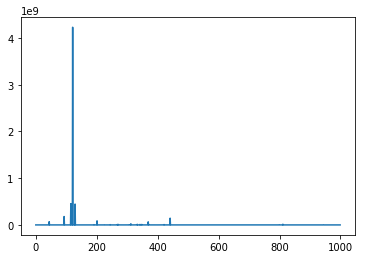

In [39]:
import numpy as np
import time
import matplotlib.pyplot as plt
# Useful scalars
# ------------------------------------------------------------------------------

# Number of factors, r
r = len(nlevels)

# Number of subjects, n
n = Z.shape[0]

# Number of random effects, q
q = np.sum(np.dot(nparams,nlevels))

# Number of fixed effects, p
p = XtX.shape[0]

# Initial estimates
# ------------------------------------------------------------------------------

# Inital beta
beta = np.ones((p,1))

# Work out e'e
ete = ssr(YtX, YtY, XtX, beta)

# Initial sigma2
sigma2 = initSigma2(ete, n)

# Inital D
Zte = ZtY - (ZtX @ beta)

# Dictionary version
Ddict = dict()
for k in np.arange(len(nparams)):
  
  Ddict[k] = makeDnnd(initDk(k, nlevels[k], ZtZ, Zte, sigma2))

# Matrix version
D = np.array([])
for i in np.arange(len(nparams)):
  
  for j in np.arange(nlevels[i]):
    
    if i == 0 and j == 0:

      D = Ddict[i]

    else:

      D = scipy.linalg.block_diag(D, Ddict[i])

# Duplication matrices
# ------------------------------------------------------------------------------
invDupMatdict = dict()
for i in np.arange(len(nparams)):
  
  invDupMatdict[i] = invDupMat(nparams[i])


t1 = time.time()
tol = np.zeros(1000)
for z in np.arange(1000):
  
  # Matrices needed later by many calculations:
  # ----------------------------------------------------------------------------
  # X transpose e and Z transpose e
  Xte = XtY - (XtX @ beta)
  Zte = ZtY - (ZtX @ beta)
  
  # Inverse of (I+Z'ZD) multiplied by D
  IplusZtZD = np.eye(q) + ZtZ @ D
  DinvIplusZtZD = D @ np.linalg.inv(IplusZtZD)
  
  # Sum of squared residuals
  ete = ssr(YtX, YtY, XtX, beta)
  
  # Derivatives
  # ----------------------------------------------------------------------------

  # Derivative wrt beta
  dldB = get_dldB(sigma2, Xte, XtZ, DinvIplusZtZD, Zte)
  
  # Derivative wrt sigma^2
  dldsigma2 = -n/(2*sigma2)  + 1/(2*(sigma2**2))*(ete - (Zte.transpose() @ DinvIplusZtZD @ Zte))
  
  # For each factor, factor k, work out dl/dD_k
  dldDdict = dict()
  for k in np.arange(len(nparams)):
    # Store it in the dictionary
    dldDdict[k] = get_dlDk(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD)

    
  # Covariances
  # ----------------------------------------------------------------------------

  # Covariance of dl/dbeta
  covdldB = (1/sigma2)*(XtX - (XtZ @ DinvIplusZtZD @ ZtX))

  # Covariance of dl/dsigma2
  covdldsigma2 = n/(2*(sigma2**2))
  
  covdldDdict = dict()
  # For each pair of factors, factor k1 and k2, work out dl/dD_k
  for k1 in np.arange(len(nparams)):

    for k2 in np.arange(k1+1):

      # Multiply by duplication matrices and save
      covdldDdict[str(k1) + str(k2)] = get_covdldDk1Dk2(k1, k2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict)

  covdldDdldsigmadict = dict()

  # For each factor, factor k, work out cov(dl/dD_k, dl/dsigma)
  for k in np.arange(len(nparams)):

    # Sum of R_(k, j) over j
    RkSum = np.zeros(nparams[k],nparams[k])

    for j in np.arange(nlevels[k]):

      # Get the indices for the kth factor jth level
      Ikj = faclev_indices(k, j, nlevels, nparams)

      # Work out R_(k, j)
      Rkj = ZtZ[np.ix_(Ikj,Ikj)] - (ZtZ[Ikj,:] @ DinvIplusZtZD @ ZtZ[:,Ikj])

      # Add together
      RkSum = RkSum + Rkj

    # Multiply by duplication matrices and save
    covdldDdldsigmadict[k] = 1/(2*sigma2) * invDupMatdict[k] @ mat2vec(RkSum)

  # 
  # ----------------------------------------------------------------------------

  # Work out the total number of paramateres
  tnp = np.int32(p + 1 + np.sum(nparams*(nparams+1)/2))

  # Indices for submatrics corresponding to Dks
  FishIndsDk = np.int32(np.cumsum(nparams*(nparams+1)/2) + p + 1)
  FishIndsDk = np.insert(FishIndsDk,0,p+1)

  # Construct the Fisher Information matrix
  FisherInfoMat = np.zeros((tnp,tnp))

  # Add dl/dbeta covariance
  FisherInfoMat[np.ix_(np.arange(p),np.arange(p))] = covdldB

  # Add dl/dsigma2 covariance
  #print(covdldsigma2)
  FisherInfoMat[p,p] = covdldsigma2

  # Add dl/dsigma2 dl/dD covariance
  for k in np.arange(len(nparams)):

    # Work out number of covariance parameters estimated
    qk = np.int32(nparams[k]*(nparams[k]+1)/2)

    # Assign to the relevant block
    FisherInfoMat[p, FishIndsDk[k]:FishIndsDk[k+1]] = covdldDdldsigmadict[k].reshape(qk)
    FisherInfoMat[FishIndsDk[k]:FishIndsDk[k+1],p] = covdldDdldsigmadict[k].reshape(qk)

  # Add dl/dD covariance
  for k1 in np.arange(len(nparams)):

    for k2 in np.arange(k1+1):

      IndsDk1 = np.arange(FishIndsDk[k1],FishIndsDk[k1+1])
      IndsDk2 = np.arange(FishIndsDk[k2],FishIndsDk[k2+1])
      FisherInfoMat[np.ix_(IndsDk1, IndsDk2)] = covdldDdict[str(k1) + str(k2)]
      FisherInfoMat[np.ix_(IndsDk2, IndsDk1)] = covdldDdict[str(k1) + str(k2)].transpose()

  paramVector = np.concatenate((beta, np.array([[sigma2]])))
  derivVector = np.concatenate((dldB, dldsigma2))

  for k in np.arange(len(nparams)):

    paramVector = np.concatenate((paramVector, mat2vech(Ddict[k])))
    derivVector = np.concatenate((derivVector, mat2vech(dldDdict[k])))

  paramVector = paramVector + (np.linalg.inv(FisherInfoMat) @ derivVector)
  tol[z] = np.amax(np.abs(np.linalg.inv(FisherInfoMat) @ derivVector))

  #print(paramVector)
  beta = paramVector[0:p]
  sigma2 = paramVector[p:(p+1)][0,0]

  for k in np.arange(len(nparams)):

    # Work out number of covariance parameters estimated
    qk = np.int32(nparams[k]*(nparams[k]+1)/2)
    
    # Work out the new estimate of D_k
    Ddict[k] = makeDnnd(vech2mat(paramVector[(p + 1 + k*qk):(p + 1 + (k+1)*qk)]))
  
  print(z)
  z=z+1
  for i in np.arange(len(nparams)):

    for j in np.arange(nlevels[i]):
      

      if i == 0 and j == 0:

        D = Ddict[i]

      else:

        D = scipy.linalg.block_diag(D, Ddict[i])
        
t2 = time.time()
print(t2-t1)

print(FisherInfoMat)
#imshow(FisherInfoMat, \
#       interpolation='nearest', vmin=-5, vmax=5, aspect='auto')

#plt.colorbar()

plt.plot(np.arange(len(tol)),tol)

[[-1.74261754]
 [ 1.98359777]
 [ 3.03135488]]
[[ 1.24022707  0.36034323  0.          0.        ]
 [ 0.36034323  5.0719078   0.          0.        ]
 [ 0.          0.         20.68631165 -0.79595202]
 [ 0.          0.         -0.79595202  0.21015464]]
0.9646341001965331
[[ 3.19186856e+09 -3.09961133e+09]
 [-3.09961133e+09  3.01125992e+09]]
[[ 8009725.82060706 -2008017.00320966]
 [-2008017.00320966  4001973.66815951]]
U estimates (R)
[[-0.16266309 -4.21724427]
 [ 1.41643004  1.41243783]
 [ 1.59527575 -1.58921871]
 [ 1.57314783  0.40497904]
 [ 1.29727291  0.93796984]
 [-1.20537013  2.19715236]
 [-0.62177368 -1.1845146 ]
 [-0.8982196  -1.34761407]
 [ 0.2105669   2.5381855 ]
 [-0.57561587 -3.43679857]
 [ 1.33808317  0.10724134]
 [-1.20676845 -2.43712662]
 [ 0.64262693  1.33629341]
 [-0.9916963  -0.08043681]
 [ 1.44782818  2.19618068]
 [-1.25815704  4.3074814 ]
 [ 0.27424557  0.87149959]
 [-0.78704685 -3.16062475]
 [-1.48916827 -0.24116661]
 [-0.47444214  3.13847411]
 [ 1.80633411  0.6436873

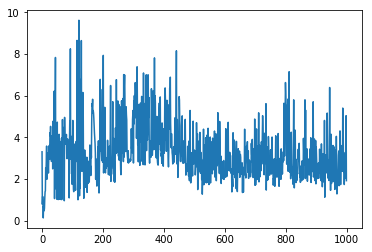

In [40]:
print(beta)

print(RFXVar_REst)

print(sigma2)
print(Ddict[0])
print(Ddict[1])


print("U estimates (R)")
print(pd.read_csv('/Data/BLMM-testdata/estd_b.csv',header=None).values.reshape(23,2))
print("U estimates (FS)")
print((DinvIplusZtZD @ Zte).reshape(23,2))
print("U true")
print(pd.read_csv('/Data/BLMM-testdata/true_b.csv',header=None).values.reshape(23,2))

plt.plot(np.arange(len(tol)),np.log10(tol))
#print(tol)

In [0]:
print()

In [0]:
print(np.min(np.abs(np.linalg.inv(FisherInfoMat)[np.linalg.inv(FisherInfoMat)!=0])))
print(paramVector)
print(derivVector)

In [0]:
k = 0
j = 3
Z2 = Z.toarray()
e = Y - X @ beta
print(np.sum(np.sum(np.abs(Z2[:,faclev_indices(k, j, nlevels, nparams)].transpose() @ Z2 - ZtZ[faclev_indices(k, j, nlevels, nparams), :]))))

print(np.sum(np.sum(np.abs(Z2[:,faclev_indices(k, j, nlevels, nparams)].transpose() @ e - Zte[faclev_indices(k, j, nlevels, nparams), :]))))

## Calculating the Information matrix

Fisher scoring requires the calculation of the information matrix, $\mathcal{I}$. This is done using the method outlined in [Demidenko 2013](https://www.wiley.com/en-us/Mixed+Models%3A+Theory+and+Applications+with+R%2C+2nd+Edition-p-9781118091579) section 3.3.


### Fisher Information Matrix function

This function calculates the Fisher Information matrix.

---

The following inputs are required for this function:

---

 - **ZtX**: Z transpose multiplied by X.
 - **ZtY**: Z transpose multiplied by Y.
 - **XtX**: X transpose multiplied by X.
 - **ZtZ**: Z transpose multiplied by Z.
 - **XtY**: X transpose multiplied by Y.
 - **YtX**: Y transpose multiplied by X.
 - **YtZ**: Y transpose multiplied by Z.
 - **XtZ**: X transpose multiplied by Z.
 - **YtY**: Y transpose multiplied by Y.

In [0]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
Xtmp = np.random.randn(10,9)

XkX = np.kron(Xtmp,Xtmp)

#print(XkX.shape[0]^2)

#print(XkX.shape[0]**2)
#print(np.power(XkX.shape[0],2))

R = (np.arange(XkX.shape[0]))
#print(R)

#print(R.shape)
Rt = mat2vec(vec2mat(R).transpose())

perm = np.argsort(Rt.reshape(Rt.shape[0]))

K = np.eye(R.shape[0],R.shape[0])
K=K[:,perm]

#print(perm)

imshow(K, \
   interpolation='nearest', aspect='auto',vmax=2,vmin=-1)
plt.colorbar()

#print(K @ R.reshape(R.shape[0],1) - Rt.reshape(R.shape[0],1))

R = (np.arange(XkX.shape[1]))
#print(R)

#print(R.shape)
Rt = mat2vec(vec2mat(R).transpose())

perm = np.argsort(Rt.reshape(Rt.shape[0]))

K2 = np.eye(R.shape[0],R.shape[0])
K2=K2[:,perm]

#print(perm)

imshow(K2, \
   interpolation='nearest', aspect='auto',vmax=2,vmin=-1)
plt.colorbar()

#print(K2 @ R.reshape(R.shape[0],1) - Rt.reshape(R.shape[0],1))

N = (K + np.eye(K.shape[0]))/2
N2 = (K2 + np.eye(K2.shape[0]))/2

#print(K.shape)
#print(K2.shape)
#print(XkX.shape)
print((N @ XkX))
#print((N @ XkX).shape)
#print((XkX @ N2).shape)

print((XkX @ N2)-(N @ XkX))

In [0]:
Xtmp = np.random.randn(100,100)

imshow(np.kron(Xtmp,Xtmp)[1:100,1:100], \
   interpolation='nearest', aspect='auto',vmax=2,vmin=-1)
plt.colorbar()

In [0]:
imshow(np.kron(Xtmp[1:10,1:10],Xtmp[1:10,1:10]), \
   interpolation='nearest', aspect='auto',vmax=2,vmin=-1)
plt.colorbar()

## Scaling up the computation (Multiple voxels)

This section has several implemented ideas for scaling up the computation to compute several similar models at once. For simplicity it is assumed here that X and Z are the same across voxels.

### Toy data for Neighbouring voxel

To assess the potential of the following ideas a toy data example is created below. The idea behind this is that we wish to calculate both the model in the example used in the previous sections and, additionally a similar model from a neighbouring voxel (variables related to the neighbouring voxel will have postfix `_n`). 

This is not a rigourous test, but just a toy example to see if we can lower the computational time in an example vaguely similar to what we may expect in reality.

#### Beta vector

In a neighbouring voxel, we would expect similar Beta values but not necessarily the same. To simulate this, I have added some normal noise with variance, 1/2, to the original beta values to obtain a new beta value.

In [0]:
# Given a beta vector this function makes a beta 
# vector for the neighbouring voxel
def beta_n(beta):
  return(beta + np.random.randn(beta.shape[0],1)/np.sqrt(2))

# Example
beta_True_n = beta_n(beta_True)
  
# print betas for comparison
print("Beta for voxel 1")
print(beta_True)
print("Beta for voxel 2")
print(beta_True_n)

#### b vector

In a neighbouring voxel, we may also expect similar b values. To simulate this, I have added some normal noise with variance, 1/2, to the original b values to obtain a new b value.

In [0]:
# Given a b vector this function makes a b
# vector for the neighbouring voxel
def b_n(b):
  return(b + np.random.randn(b.shape[0],1)/np.sqrt(2))

# Example
b_True_n = b_n(b_True)
  
# print bs for comparison
print("b for voxel 1 (first 5 elements)")
print(b_True[1:5])
print("b for voxel 2 (first 5 elements)")
print(b_True_n[1:5])

 #### Y vector (New response)
 
I now generate a new response vector with the new beta and b values for the neighbouring voxel.

In [0]:
# Neighbouring voxels response vector
Y_n = np.matmul(X,beta_True_n)+Z*b_True_n+np.random.randn(1000,1)


### Product Matrices

All products of matrices are calculated beforehand as it is both more computationally efficient and also similar to the setting we are interested in. For the neighbouring voxel only those involving the Y vector (response) need be recalculated as X and Z have not changed between voxel in this example.

In [0]:
# Z tranpose Y_n
ZtY_n=cvxopt.spmatrix.trans(Z)*Y_n

# X tranpose Y_n
XtY_n=cvxopt.matrix.trans(X)*Y_n

# Y_n tranpose X
YtX_n=cvxopt.matrix.trans(Y_n)*X

# Y_n transpose Z
YtZ_n=cvxopt.matrix.trans(Y_n)*Z

# Y_n tranpose Y_n
YtY_n=cvxopt.matrix.trans(Y_n)*Y_n

#### Time efficiency

What is really important here is not the estimate values (assuming they are correct), but the time taken to do this for both voxels. In the below, the two voxels are estimated 100 times twice, once reusing the estmate from the first voxel in estimating the second, and once computing the voxels completely seperately.

**Conclusion:** 

#### Idea 1: Broadcast everything

The title for this idea speaks for itself. The `scipy` library does not allow for broadcasting of sparse matrices, however the libraries `sparse` and `dask` supposedly do (little documentation is available for this however). If these can be used for broadcasting then this algorithm might be reasonably streamlinable for large numbers of voxels.

In [0]:
# TODO